In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/ANNOTATORS
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/SHA256SUMS.txt
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/RECORDS
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/SUBJECT-INFO
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/RECORDS-WITH-SEIZURES
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/shoeb-icml-2010.pdf
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_13.edf
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_37.edf
/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_58.edf.seizures

In [3]:
!pip install antropy
# Please start by installing those two Python packages
!pip3 install pyedflib
!pip3 install PyWavelets

import pyedflib as edf
import numpy as np
import glob
import pandas as pd
import random
import antropy as ent
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.0 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16878 sha256=681766d3c8a7759f06aefd65a9ce6cd0d50bd55b6e21bcae1181510c7e7572ee
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.1 MB/s eta 0:00:00a 0:00:01


In [4]:
WINDOW_STEP = 256

files = glob.glob('/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/*.edf')

seizure_period_foreach_file = [
    (2996, 3036),
    (1467, 1494),
    (1732, 1772),
    (1015, 1066),
    (1720, 1810),
    (327, 420),
    (1862, 1963),
    (130, 212),
    (2972, 3053),
    (362, 414),
    (731, 796),
    (432, 501),
    (2162, 2214),
    (7804, 7853),
    (1679, 1781),
    (3782, 3898),
    (417, 532),
    (1086, 1196),
    (2317, 2413),
    (2451, 2571),
    (2348, 2465),
    (327, 347),
    (6211, 6231),
    (12500, 12516),
    (10833, 10845),
     (506, 519),
    (7799, 7811),
    (9387, 9403),
    (4920, 5006),
    (3285, 3381),
    (13688, 13831),
    (2670, 2841),
    (2856, 3046),
    (2988, 3122),
    (2417, 2577),
    (2083, 2347),
    (12231, 12295),
    (2951, 3030),
    (9196, 9267),
    (5299, 5361),
    (6313, 6348),
    (6888, 6958),
    (2382, 2447),
    (3021, 3079),
    (3801, 3877),
    (4618, 4707),
    (1383, 1437),
]
seizure_period_concat_with_file = zip(files, seizure_period_foreach_file)

seizure_period_concat_with_file = [(file_name, start, end) 
                                    for file_name, (start, end) in seizure_period_concat_with_file]

signals = []

for file in files:
    with edf.EdfReader(file) as edf_reader:
        signal_labels = edf_reader.getSignalLabels()
        
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        
        buffers = np.zeros((2, edf_reader.getNSamples()[0]))
        
        buffers[0] = edf_reader.readSignal(fz_cz_index)
        buffers[1] = edf_reader.readSignal(cz_pz_index)
        
        array_buffer = np.array(buffers)
        signals.append(array_buffer)

len(signals)

42

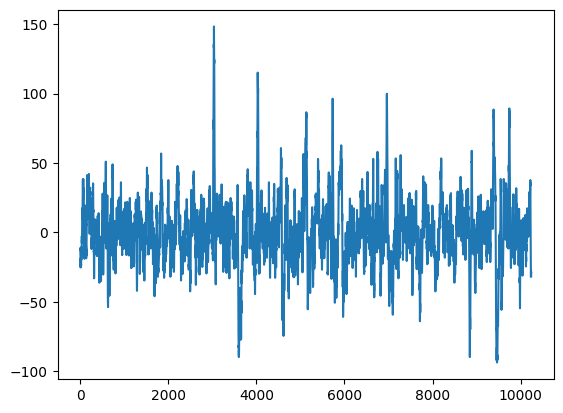

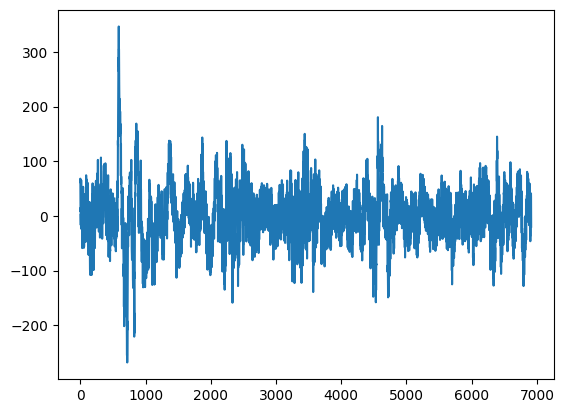

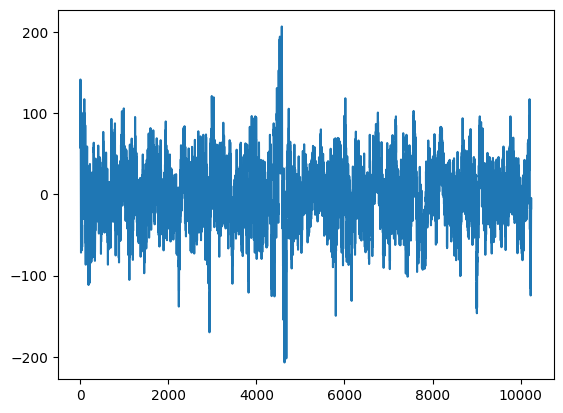

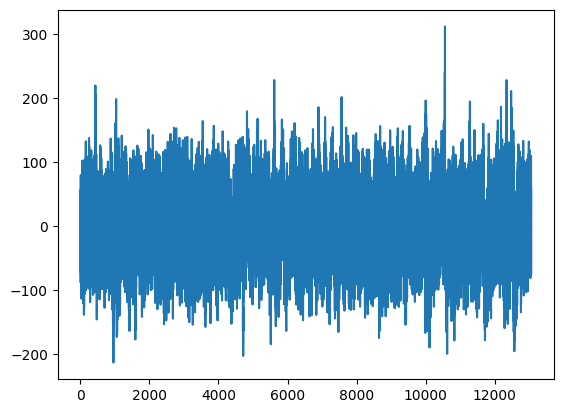

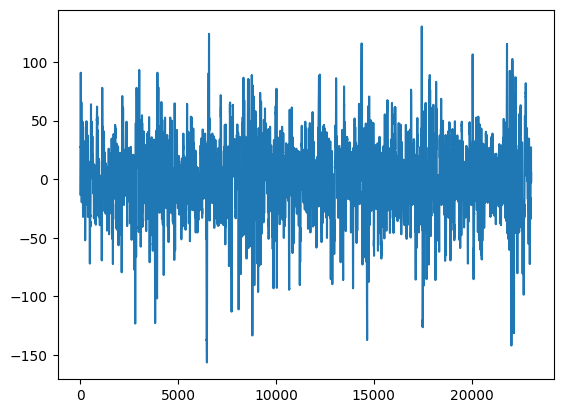

In [5]:
sample_signals = seizure_period_concat_with_file[0:5]

for i, signal in enumerate(sample_signals):
    filename, start, end = signal
    plt.plot(signals[i][0][start * WINDOW_STEP:end * WINDOW_STEP])
    plt.show()

In [6]:
WINDOW_SIZE = 5 * WINDOW_STEP

seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
seizure_y_labels = []

for index in range(len(signals)):
    try:
        start_time = seizure_period_concat_with_file[index][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[index][2] * WINDOW_STEP
        for j in range(start_time, end_time, WINDOW_SIZE):
            seizure_signals = np.append(seizure_signals, 
                                        np.array([signals[index][:, j:j + WINDOW_SIZE]]), axis=0)
            seizure_y_labels.append(1)
    except:
        continue

seizure_signals.shape

(536, 2, 1280)

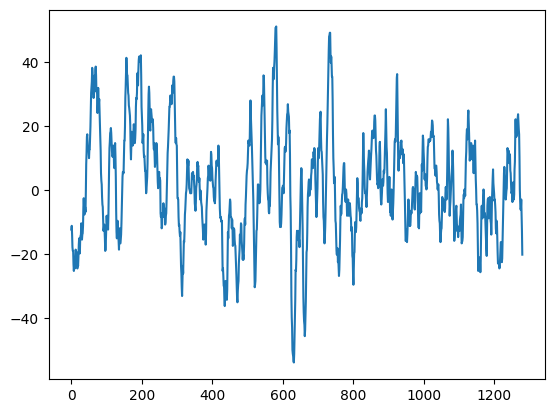

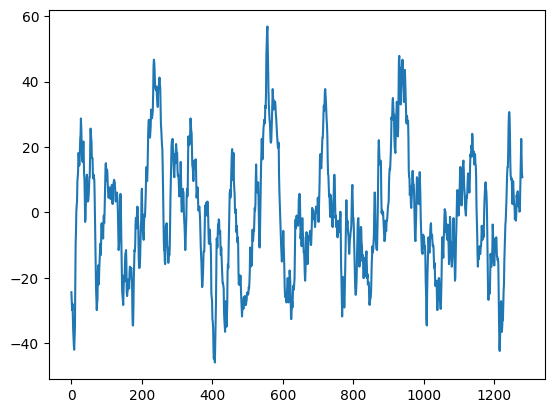

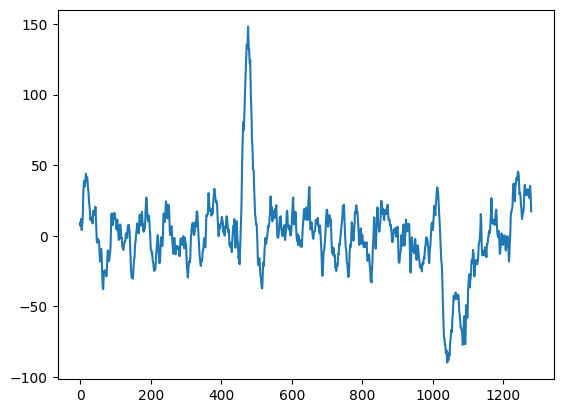

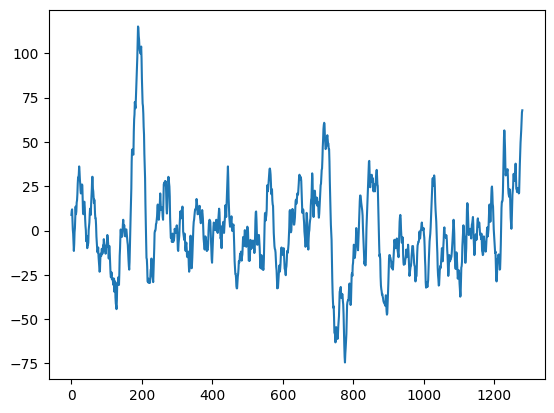

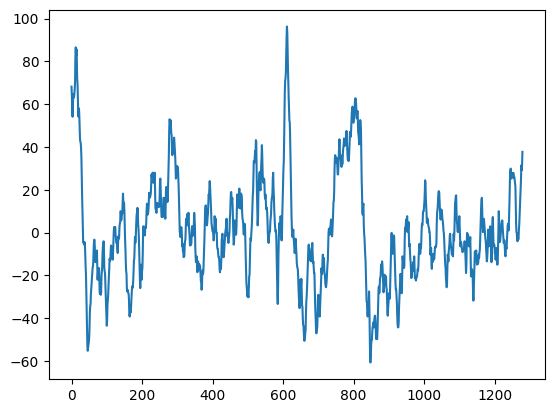

In [7]:
sample_signals = seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

In [8]:
def remove_noise(signals):
    for index in range(len(signals)):
        low_range = int(0.05 * len(signals[i][0]))
        high_range = int(0.95*len(signals[i][0]))
        signals[i] = signals[i][:,low_range:high_range]

    return signals

signals_without_noise = remove_noise(signals)

len(signals_without_noise)

42

In [9]:
for i in range(len(signals_without_noise)):
    try:
        start_time = seizure_period_concat_with_file[i][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[i][2] * WINDOW_STEP
        signals_without_noise[i] = np.delete(signals_without_noise[i], np.s_[start_time:end_time], axis=1)
    except:
        continue

len(signals_without_noise)

42

In [10]:
WINDOW_SIZE = 5 * WINDOW_STEP

non_seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
non_seizure_y_labels = []

for index in range(len(signals_without_noise)):
    try:
        for j in range(WINDOW_STEP):
            random_index = random.randint(0, len(signals_without_noise[i][0]) - WINDOW_SIZE)
            non_seizure_signals = np.append(non_seizure_signals, 
                                        np.array([signals_without_noise[index][:, random_index:random_index + WINDOW_SIZE]]), axis=0)
            non_seizure_y_labels.append(0)
    except:
        continue

non_seizure_signals.shape

(4112, 2, 1280)

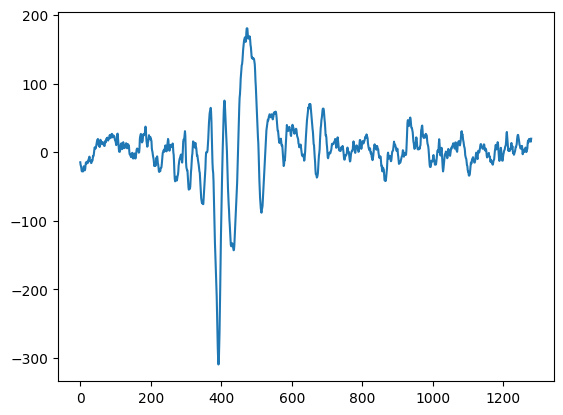

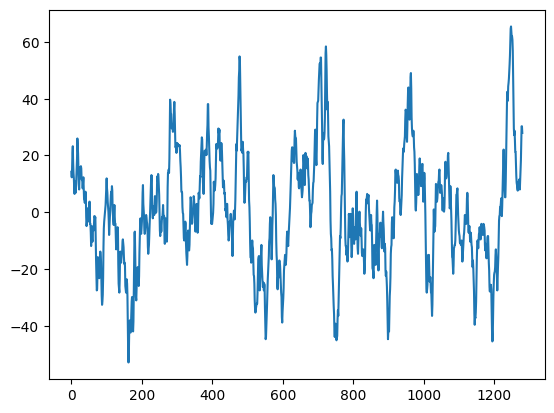

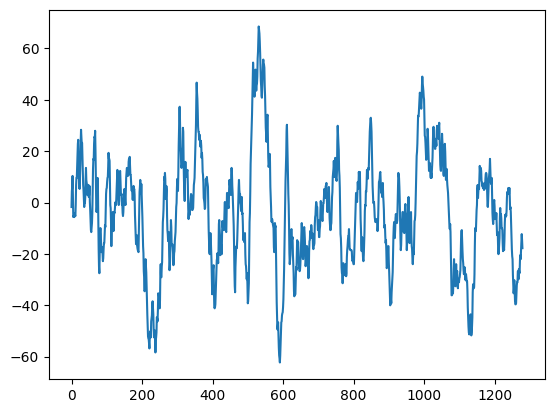

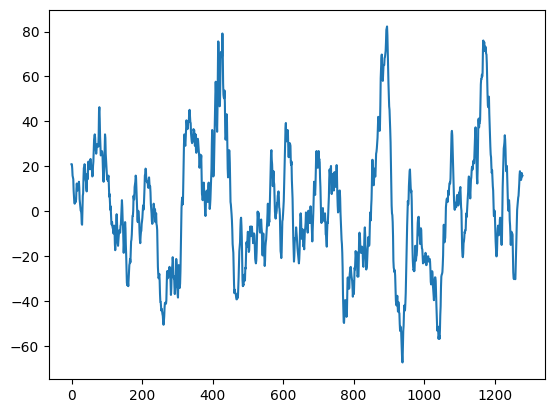

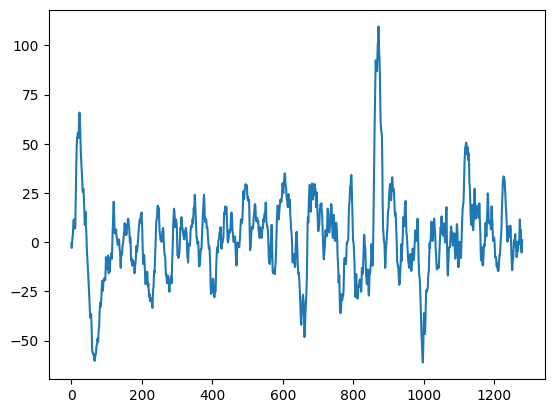

In [11]:
sample_signals = non_seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

In [12]:
final_signals = np.zeros((0, 2, WINDOW_SIZE))
final_y_labels = []

In [13]:
final_signals = np.append(seizure_signals, non_seizure_signals, axis=0)
final_y_labels = np.append(seizure_y_labels, non_seizure_y_labels, axis=0)

print(final_signals.shape, final_y_labels.shape)

(4648, 2, 1280) (4648,)


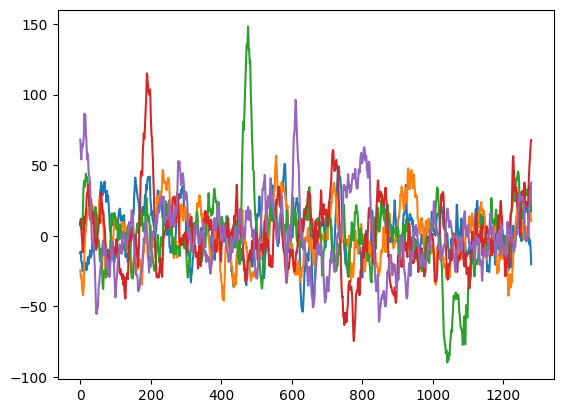

In [14]:
for i in range(len(final_signals[0:5])):
    plt.plot(final_signals[i][0])

plt.show()

In [15]:
def func_var(data):
    return np.var(data, axis=2)

def func_std(data):
    return np.std(data, axis=2)

def func_mean(data):
    return np.mean(data, axis=2)

def func_fft(data):
    return np.fft.fft(data, axis=2)

def func_fft_var(data):
    fft = np.fft.fft(data, axis=2)
    return np.var(fft, axis=2)

def func_fft_std(data):
    fft = np.fft.fft(data, axis=2)
    return np.std(fft, axis=2)

def func_fft_mean(data):
    fft = np.fft.fft(data, axis=2)
    return np.mean(fft, axis=2)

def func_fft2_var(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.var(fft2_abs, axis=2)

def func_fft2_std(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.std(fft2_abs, axis=2)

def func_fft2_mean(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.mean(fft2_abs, axis=2)

def func_power(data):
    return np.sum(np.square(data), axis=2)

# calculate power spectral density for each signal
def func_power_specular_var(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_std(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_mean(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_complexity(data):
    fft = np.fft.fft(data)
    return np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)

def func_zero_crossing_rate(data):
    return np.sum(np.abs(np.diff(np.sign(data), axis=2)), axis=2)

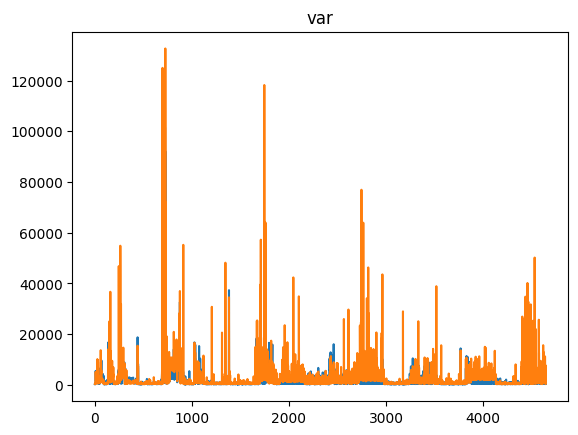

In [16]:
var = func_var(final_signals)

plt.title('var')
plt.plot(var)
plt.show()

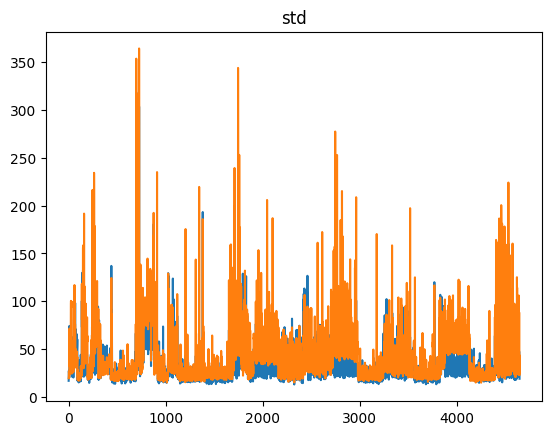

In [17]:
std = func_std(final_signals)

plt.title('std')
plt.plot(std)
plt.show()

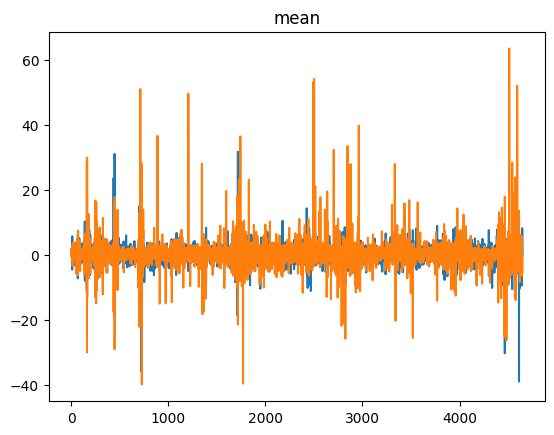

In [18]:
mean = func_mean(final_signals)

plt.title('mean')
plt.plot(mean)
plt.show()

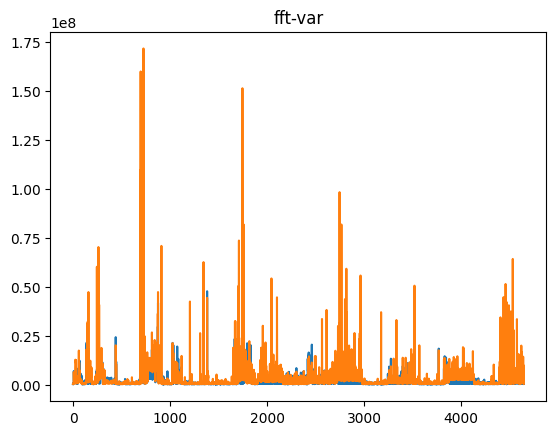

In [19]:
fft_var = func_fft_var(final_signals)

plt.title('fft-var')
plt.plot(fft_var)
plt.show()

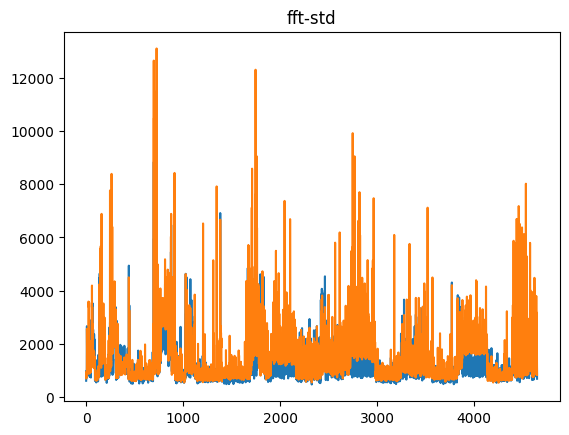

In [20]:
fft_std = func_fft_std(final_signals)

plt.title('fft-std')
plt.plot(fft_std)
plt.show()

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


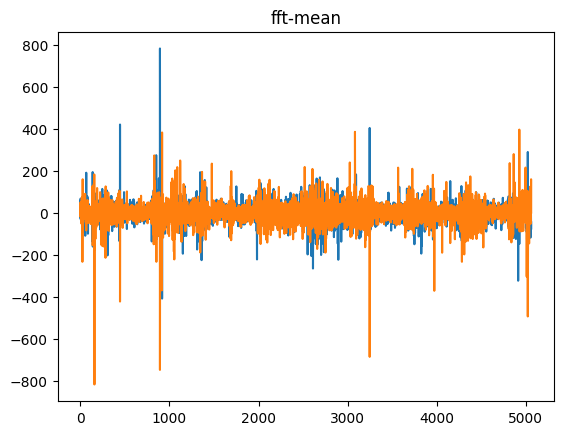

In [22]:
fft_mean = func_fft_mean(final_signals)

plt.title('fft-mean')
plt.plot(fft_mean)
plt.show()

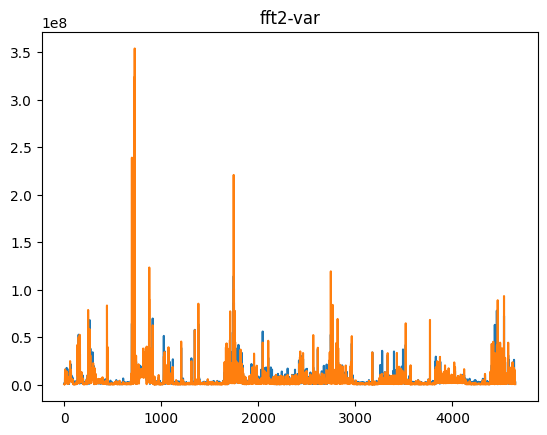

In [21]:
fft2_var = func_fft2_var(final_signals)

plt.title('fft2-var')
plt.plot(fft2_var)
plt.show()

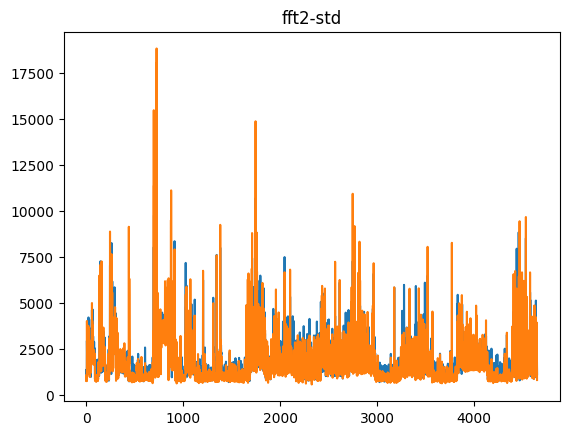

In [22]:
fft2_std = func_fft2_std(final_signals)

plt.title('fft2-std')
plt.plot(fft2_std)
plt.show()

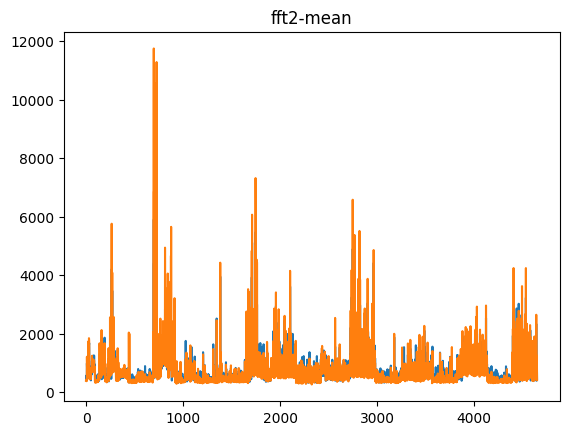

In [23]:
fft2_mean = func_fft2_mean(final_signals)

plt.title('fft2-mean')
plt.plot(fft2_mean)
plt.show()

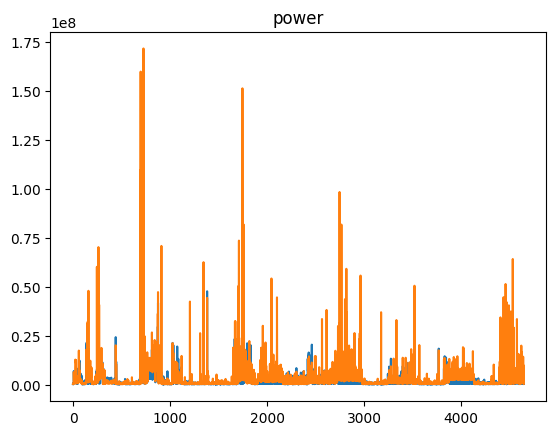

In [24]:
power = func_power(final_signals)

plt.title('power')
plt.plot(power)
plt.show()

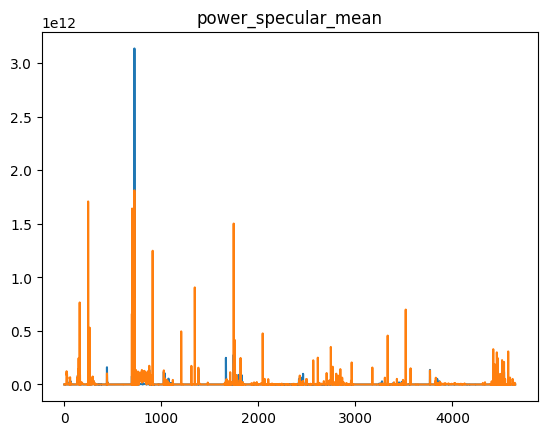

In [25]:
power_specular_mean = func_power_specular_mean(final_signals)

plt.title('power_specular_mean')
plt.plot(power_specular_mean)
plt.show()

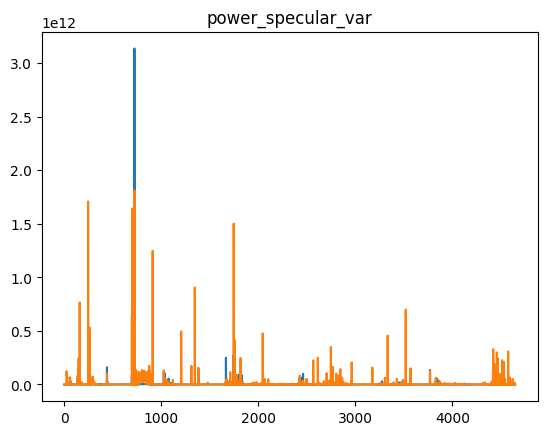

In [26]:
power_specular_var = func_power_specular_var(final_signals)

plt.title('power_specular_var')
plt.plot(power_specular_var)
plt.show()

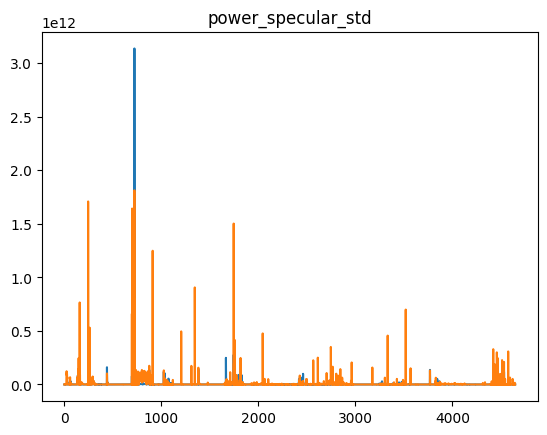

In [27]:
power_specular_std = func_power_specular_std(final_signals)

plt.title('power_specular_std')
plt.plot(power_specular_std)
plt.show()

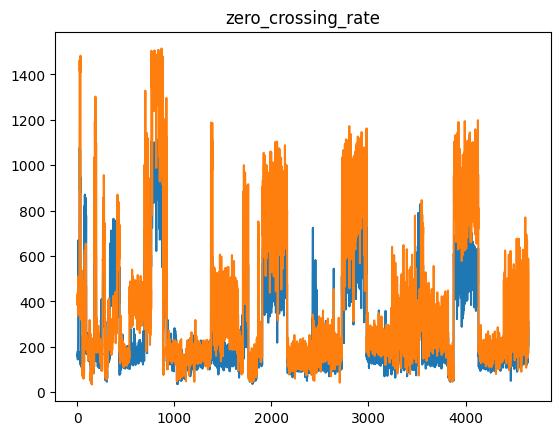

In [28]:
zero_crossing_rate = func_zero_crossing_rate(final_signals)

plt.title('zero_crossing_rate')
plt.plot(zero_crossing_rate)
plt.show()

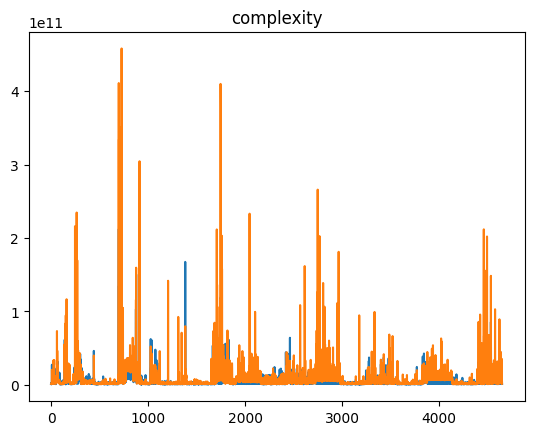

In [29]:
complexity = func_complexity(final_signals)

plt.title('complexity')
plt.plot(complexity)
plt.show()

In [30]:
features = np.concatenate((var
                          ,std
                          ,mean
                          ,fft_var
                          ,fft_std
                          ,fft2_var
                          ,fft2_std
                          ,fft2_mean
                          ,power
                          ,power_specular_var
                          ,power_specular_std
                          ,power_specular_mean
                          ,zero_crossing_rate
                          ,complexity), axis=1)

features.shape

(4648, 28)

0.8634408602150537
[[803   0]
 [127   0]]


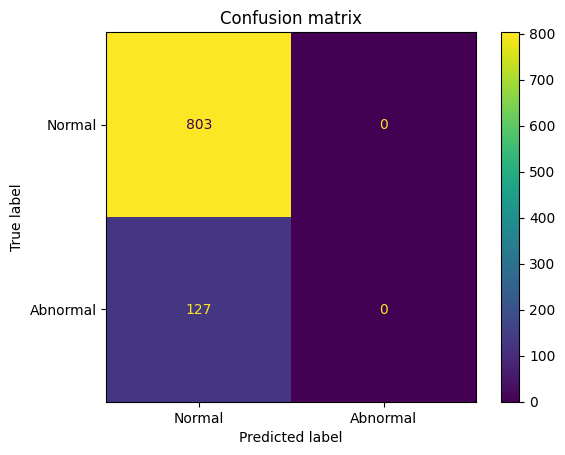

In [31]:
x_train, x_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

clf.fit(x_train, y_train)

y_prediction = clf.predict(x_test)

print(accuracy_score(y_test, y_prediction))

print(confusion_matrix(y_test, y_prediction))

cm = confusion_matrix(y_test, y_prediction)

display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Abnormal'])
display.plot()
display.ax_.set_title('Confusion matrix')
plt.show()

In [33]:
x_train, x_test, y_train, y_test = train_test_split(final_signals, final_y_labels, test_size=0.2, random_state=42)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [34]:
KERNEL_SIZE = 5
FILTER_SIZE = 256
POOL_SIZE = 2
DROPOUT = 0.3
DENSE_1 = 256
DENSE_2 = 2

sequential = Sequential()

sequential.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 2
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 4
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Flatten())

#add our features to the last fully connected layer
sequential.add(Dense(DENSE_1, activation='relu'))
sequential.add(Dense(DENSE_2, activation='softmax'))

sequential.summary()

sequential.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1276, 256)         2816      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 638, 256)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 638, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 317, 128)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 317, 128)          0

In [35]:
x_train = x_train.reshape(x_train.shape[0], WINDOW_SIZE, 2).astype('float32')
x_test = x_test.reshape(x_test.shape[0], WINDOW_SIZE, 2).astype('float32')

In [ ]:
sequential.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
117/117 - 53s - loss: 1.6584 - accuracy: 0.8765 - 53s/epoch - 455ms/step
Epoch 2/10
117/117 - 51s - loss: 0.4291 - accuracy: 0.8900 - 51s/epoch - 438ms/step
Epoch 3/10
117/117 - 51s - loss: 0.3821 - accuracy: 0.8900 - 51s/epoch - 438ms/step
Epoch 4/10
117/117 - 52s - loss: 0.3476 - accuracy: 0.8900 - 52s/epoch - 442ms/step
Epoch 5/10
117/117 - 51s - loss: 0.3484 - accuracy: 0.8900 - 51s/epoch - 440ms/step
Epoch 6/10
117/117 - 52s - loss: 0.3467 - accuracy: 0.8897 - 52s/epoch - 447ms/step
Epoch 7/10
117/117 - 52s - loss: 0.3467 - accuracy: 0.8900 - 52s/epoch - 444ms/step
Epoch 8/10
117/117 - 52s - loss: 0.3491 - accuracy: 0.8900 - 52s/epoch - 449ms/step
Epoch 9/10
117/117 - 52s - loss: 0.3475 - accuracy: 0.8897 - 52s/epoch - 448ms/step
Epoch 10/10
117/117 - 52s - loss: 0.3473 - accuracy: 0.8900 - 52s/epoch - 443ms/step


In [40]:
model_loss, model_accuracy = sequential.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

32/32 - 3s - loss: 0.3614 - accuracy: 0.8814 - 3s/epoch - 84ms/step
CNN - Loss: 0.3614373803138733, Accuracy: 0.8814229369163513


In [41]:
y_prediction = sequential.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

32/32 [==============================] - 3s 79ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       892
           1       0.50      0.01      0.02       120

    accuracy                           0.88      1012
   macro avg       0.69      0.50      0.48      1012
weighted avg       0.84      0.88      0.83      1012



In [42]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.0011210762331838565, missing rate: 0.9916666666666667


In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

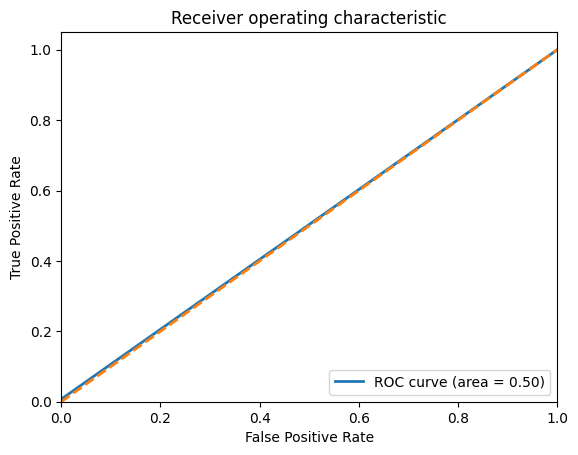

In [44]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [45]:
LEARNING_RATE = 0.01

sequential_b = Sequential()
sequential_b.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential_b.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential_b.add(BatchNormalization())
sequential_b.add(Conv1D(filters=FILTER_SIZE / 2
                ,kernel_size=KERNEL_SIZE
                ,activation='relu'
                ,input_shape=(WINDOW_SIZE, 2)))

sequential_b.add(Flatten())

sequential_b.add(Dense(features.shape[1], activation='relu'))
sequential_b.add(Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

sequential_b.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sequential_b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1276, 256)         2816      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 638, 256)         0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 638, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_7 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 flatten_2 (Flatten)         (None, 81152)             0         
                                                                 
 dense_4 (Dense)             (None, 28)               

In [46]:
sequential_b.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
127/127 - 44s - loss: 0.6055 - accuracy: 0.8948 - 44s/epoch - 350ms/step
Epoch 2/10
127/127 - 43s - loss: 0.1982 - accuracy: 0.8980 - 43s/epoch - 338ms/step
Epoch 3/10
127/127 - 43s - loss: 0.1478 - accuracy: 0.9345 - 43s/epoch - 338ms/step
Epoch 4/10
127/127 - 44s - loss: 0.1289 - accuracy: 0.9400 - 44s/epoch - 343ms/step
Epoch 5/10
127/127 - 43s - loss: 0.1431 - accuracy: 0.9296 - 43s/epoch - 338ms/step
Epoch 6/10
127/127 - 43s - loss: 0.1215 - accuracy: 0.9400 - 43s/epoch - 339ms/step
Epoch 7/10
127/127 - 44s - loss: 0.1308 - accuracy: 0.9365 - 44s/epoch - 347ms/step
Epoch 8/10
127/127 - 43s - loss: 0.1119 - accuracy: 0.9449 - 43s/epoch - 341ms/step
Epoch 9/10
127/127 - 43s - loss: 0.1098 - accuracy: 0.9479 - 43s/epoch - 338ms/step
Epoch 10/10
127/127 - 43s - loss: 0.1097 - accuracy: 0.9471 - 43s/epoch - 341ms/step


In [47]:
model_loss, model_accuracy = sequential_b.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

32/32 - 2s - loss: 0.1907 - accuracy: 0.9229 - 2s/epoch - 78ms/step
CNN - Loss: 0.19072365760803223, Accuracy: 0.9229248762130737


In [48]:
y_prediction = sequential_b.predict(x_test)
sequential_b.save('model.h5')
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

32/32 [==============================] - 3s 75ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       892
           1       0.66      0.71      0.69       120

    accuracy                           0.92      1012
   macro avg       0.81      0.83      0.82      1012
weighted avg       0.93      0.92      0.92      1012



In [49]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.04820627802690583, missing rate: 0.2916666666666667


In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

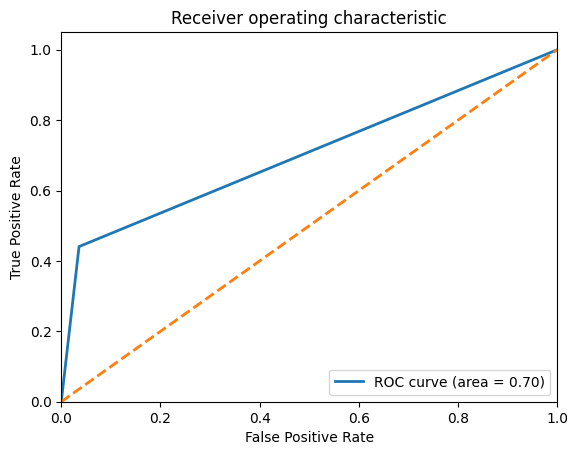

In [57]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
import pickle


In [53]:
# Assuming 'sequential' is your trained Keras Sequential model
model_filename = 'trained_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(sequential, file)


In [60]:
# Assuming 'sequential' is your trained Keras Sequential model
model_filename = 'trained_sequential_b.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(sequential_b, file)

In [61]:
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
